## 7차 과제 - 추천시스템을 구현해보자
- 주체: 추천시스템 구현(콘텐츠 기반 협업 필터링, 행렬 분해)
- 데이터: 영화 데이터
https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
- 사용 라이브러리: pandas, numpy, sklearn, surprise 등등

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 콘텐츠 기반 필터링
사용자가 특정 영화를 감사하고 해당 영화에 대해 긍정적인 반응을 보였다면 그 영화와 비슷한 특성/속성, 구성요소(ex. 장르, 감독, 배우, 평점, etc) 등을 가진 다른 영화를 추천하도록 하겠습니다. 장르 컬럼 값의 유사도를 비교한 뒤 그 중 높은 평점을 가지는 영화를 추천하는 방식입니다.

1.1 데이터를 불러오고 shape과 앞 5개의 행을 출력하세요.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DAT/csv/tmdb_5000_movies.csv')
print(df.shape)
df.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


1.2 총 20개의 feature로 구성되어 있으나 이 중 추천시스템에 활용할 컬럼인 id, title, genres, vote_average(평균 평점), vote_count(평점 투표수), popularity(영화 인기 정도), keywords(영화에 대한 키워드), overview(영화에 대한 개요 설명)만 추출하세요.

In [4]:
movie_df = df[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]
movie_df.head()

,id,title,genres,vote_average,vote_count,popularity,keywords,overview
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",7.2,11800,150.437577,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",6.9,4500,139.082615,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.3,4466,107.376788,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",7.6,9106,112.312950,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Following the death of District Attorney Harve...
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.1,2124,43.926995,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","John Carter is a war-weary, former military ca..."


1.3 genres와 keywords 컬럼의 경우 list안에 다수의 dictionary 형태의 문자열로 구성되어 있습니다. 한 영화가 한개의 장르나 키워드만 가지고 있지 않기 때문으로(ex. 영화 아바타의 장르는 Aciton과 Adventure) ast 모듈에 있는 literal_eval() 함수를 통해 해당 문자열을 list 객체로 변환하세요.

In [5]:
from ast import literal_eval
movie_df['genres'] = movie_df['genres'].apply(literal_eval)
movie_df['keywords'] = movie_df['keywords'].apply(literal_eval)

##키워드 분류는 직접해보세요!


<ipython-input-5-dfe510e269fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['genres'] = movie_df['genres'].apply(literal_eval)
<ipython-input-5-dfe510e269fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['keywords'] = movie_df['keywords'].apply(literal_eval)


In [6]:
movie_df

,id,title,genres,vote_average,vote_count,popularity,keywords,overview
0,19995,Avatar,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",7.2,11800,150.437577,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,4500,139.082615,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...","Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",6.3,4466,107.376788,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",7.6,9106,112.312950,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",Following the death of District Attorney Harve...
4,49529,John Carter,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",6.1,2124,43.926995,"[{'id': 818, 'name': 'based on novel'}, {'id':...","John Carter is a war-weary, former military ca..."
...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",6.6,238,14.269792,"[{'id': 5616, 'name': 'united states–mexico ba...",El Mariachi just wants to play his guitar and ...
4799,72766,Newlyweds,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",5.9,5,0.642552,[],A newlywed couple's honeymoon is upended by th...
4800,231617,"Signed, Sealed, Delivered","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",7.0,6,1.444476,"[{'id': 248, 'name': 'date'}, {'id': 699, 'nam...","""Signed, Sealed, Delivered"" introduces a dedic..."
4801,126186,Shanghai Calling,[],5.7,7,0.857008,[],When ambitious New York attorney Sam is sent t...


1.4 genres와 keywords 컬럼에서 각각 장르명과 키워드만 추출하세요(apply lambda 식 활용).

In [7]:
movie_df['genres'] = movie_df['genres'].apply(lambda x : [y['name'] for y in x])
movie_df['keywords'] = movie_df['keywords'].apply(lambda x : [y['name'] for y in x])
movie_df[['genres', 'keywords']][:1]

<ipython-input-7-0297a7e441dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['genres'] = movie_df['genres'].apply(lambda x : [y['name'] for y in x])
<ipython-input-7-0297a7e441dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['keywords'] = movie_df['keywords'].apply(lambda x : [y['name'] for y in x])


,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon..."


In [8]:
movie_df

,id,title,genres,vote_average,vote_count,popularity,keywords,overview
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,150.437577,"[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500,139.082615,"[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466,107.376788,"[spy, based on novel, secret agent, sequel, mi...",A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,9106,112.312950,"[dc comics, crime fighter, terrorist, secret i...",Following the death of District Attorney Harve...
4,49529,John Carter,"[Action, Adventure, Science Fiction]",6.1,2124,43.926995,"[based on novel, mars, medallion, space travel...","John Carter is a war-weary, former military ca..."
...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[Action, Crime, Thriller]",6.6,238,14.269792,"[united states–mexico barrier, legs, arms, pap...",El Mariachi just wants to play his guitar and ...
4799,72766,Newlyweds,"[Comedy, Romance]",5.9,5,0.642552,[],A newlywed couple's honeymoon is upended by th...
4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",7.0,6,1.444476,"[date, love at first sight, narration, investi...","""Signed, Sealed, Delivered"" introduces a dedic..."
4801,126186,Shanghai Calling,[],5.7,7,0.857008,[],When ambitious New York attorney Sam is sent t...


1.5 유사도 측정을 위해 장르 컬럼 값을 문자열로 변경한 후 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교하겠습니다. 먼저 list 객체 값으로 구성된 genres 컬럼에 대해 apply(lambda x : (' ').join(x)를 적용해 개별 요소를 공백 문자로 구분하는 문자열로 변환 후 genres_listeral 컬럼으로 저장하세요.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

#CounterVectorizer 적용을 위해 공백문자로 word 단위가 구분되는 문자열로 변환

movie_df['genres_literal'] = movie_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movie_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


<ipython-input-9-c63b3bef87f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['genres_literal'] = movie_df['genres'].apply(lambda x : (' ').join(x))


In [10]:
genre_mat.shape

(4803, 276)

In [11]:
movie_df

,id,title,genres,vote_average,vote_count,popularity,keywords,overview,genres_literal
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,150.437577,"[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500,139.082615,"[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466,107.376788,"[spy, based on novel, secret agent, sequel, mi...",A cryptic message from Bond’s past sends him o...,Action Adventure Crime
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,9106,112.312950,"[dc comics, crime fighter, terrorist, secret i...",Following the death of District Attorney Harve...,Action Crime Drama Thriller
4,49529,John Carter,"[Action, Adventure, Science Fiction]",6.1,2124,43.926995,"[based on novel, mars, medallion, space travel...","John Carter is a war-weary, former military ca...",Action Adventure Science Fiction
...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[Action, Crime, Thriller]",6.6,238,14.269792,"[united states–mexico barrier, legs, arms, pap...",El Mariachi just wants to play his guitar and ...,Action Crime Thriller
4799,72766,Newlyweds,"[Comedy, Romance]",5.9,5,0.642552,[],A newlywed couple's honeymoon is upended by th...,Comedy Romance
4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",7.0,6,1.444476,"[date, love at first sight, narration, investi...","""Signed, Sealed, Delivered"" introduces a dedic...",Comedy Drama Romance TV Movie
4801,126186,Shanghai Calling,[],5.7,7,0.857008,[],When ambitious New York attorney Sam is sent t...,


1.6 변환된 4803개의 레코드와 276개의 개별 단어 피처로 구성된 피처 벡터 행렬에 대해 cosine_similarity()를 이용해 코사인 유사도를 계산하세요.

<figure>
    <img src="https://kr.mathworks.com/help/textanalytics/ref/evaluatecosinedocumentsimilaritiesusingbagofwordsmodelexample_01_ko_KR.png">
</figure>

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


1.8 movie_df에 대해 장르 기준으로 콘텐츠 기반 필터링을 수행하기 위해서는 개별 레코드에 대하여 가장 장르 유사도가 높은 순으로 추출해야 합니다. 이를 위해 genre_sim의 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값을 추출하세요.

In [13]:
genre_sim_sorted_ind = genre_sim.argsort()[:,::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


1.9 위에서 구한 행렬의 의미를 작성하세요.

영화 장르 간의 코사인 유사도를 행렬로 표현해놓았다. 코사인 유사도가 1에 가까울 수록 두 벡터는 높은 유사성을 보인다고 할 수 있다. 코사인 유사도가 0인 경우에는 두 벡터는 관련성이 없고 음수인 경우에는 두 벡터가 반대 관계를 갖는다고 할 수 있다. 행렬의 대각선은 코사인 유사도가 1이다. 이 말인 즉슨, 자기 자신과 코사인 유사도를 구한 것이라고 볼 수 있다.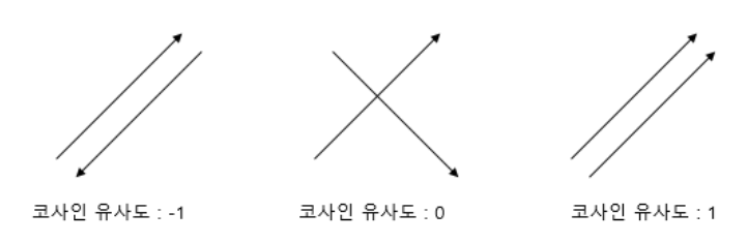

1.10 장르 유사도에 따라 영화를 추천하는 함수를 구현해보겠습니다. 고객이 선정한 추천 기준이 되는 영화 제목, 추천할 영화 건수를 입력하면 추천 영화 정보를 가지는 DataFrame을 반환합니다.

In [14]:
def find_sim_movie(df, sorted_ind, title_name, top_n):
    #인자로 입력된 movies_df에서 'title'컬럼이 입력된 title_name 값인 DataFrame 추출
    title_movie = df[df['title'] == title_name]

    #title_named를 가진 DataFrmae의 index객체를 ndarray로 반환하고
    #sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]

    #추출된 top_n index 출력(top_n index는 2차원 데이터임)
    #DataFrame에서 index로 사용하기 위해 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)

    return df.iloc[similar_indexes]

1.11 위에서 작성한 함수를 이용해 영화 '대부'와 장르별로 유사한 영화 10개를 추천해보세요.

In [15]:
similar_movies = find_sim_movie(movie_df, genre_sim_sorted_ind, 'The Godfather', 5)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7


1.12 추천이 잘 된 영화도 있으나 애매한 영화들(ex. Kids는 뭐지..)도 있고 평점이 낮거나 아예 0인 경우도 존재합니다. 이를 개선하기 위해 더 많은 후보군을 선정한 뒤 영화의 평점에 따라 필터링해서 최종 추천하는 방식으로 변경해보겠습니다. 이를 위해 vote_average 값을 이용하는데 소수의 관객이 특정 영화에 높거나 낮은 평점을 부여하여 왜곡된 데이터가 존재하므로 sort_values를 통해 평점 오름차순으로 확인해보겠습니다.

In [16]:
movie_df[['title','vote_average','vote_count']].sort_values('vote_average',ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


1.13 위에서 알 수 있듯이 듣보 영환데 쇼생크 탈출보다 위에 있네요.. 이를 개선하기 위해 새로운 평가 방식을 적용하겠습니다. 유명 영화 평점 사이트인 IMDB에서 사용하는 가중 평점을 사용합니다.

$$ WR = (v/(v+m)) * R + (m/(v+m)) * C $$

- WR: Weighted Rating(가중 평점)

- v: 개별 영화에 평점을 투표한 횟수

- m: 평점을 부여하기 위한 최소 투표 횟수

- R: 개별 영화에 대한 평균 평점

- C: 전체 영화에 대한 평균 평점

여기서 V는 movie_df의 'vote_count', R은 'vote_average'값에 해당합니다. C와 m은 직접 구해보도록 하겠습니다(m은 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 선정).

In [17]:
C = movie_df['vote_average'].mean()
m = movie_df['vote_count'].quantile(0.6)

print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


1.14 이들을 활용해서 기존 평점을 새로운 가중 평점으로 변경하는 함수를 생성하겠습니다.

In [18]:
def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']

    return ((v/(v+m)) * R) + ((m/(m+v)) * C)

movie_df['weighted_vote'] = movie_df.apply(weighted_vote_average, axis=1)

<ipython-input-18-c6f39074f5d1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['weighted_vote'] = movie_df.apply(weighted_vote_average, axis=1)


In [19]:
movie_df

,id,title,genres,vote_average,vote_count,popularity,keywords,overview,genres_literal,weighted_vote
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,11800,150.437577,"[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",Action Adventure Fantasy Science Fiction,7.166301
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,4500,139.082615,"[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...",Adventure Fantasy Action,6.838594
2,206647,Spectre,"[Action, Adventure, Crime]",6.3,4466,107.376788,"[spy, based on novel, secret agent, sequel, mi...",A cryptic message from Bond’s past sends him o...,Action Adventure Crime,6.284091
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,9106,112.312950,"[dc comics, crime fighter, terrorist, secret i...",Following the death of District Attorney Harve...,Action Crime Drama Thriller,7.541095
4,49529,John Carter,"[Action, Adventure, Science Fiction]",6.1,2124,43.926995,"[based on novel, mars, medallion, space travel...","John Carter is a war-weary, former military ca...",Action Adventure Science Fiction,6.098838
...,...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[Action, Crime, Thriller]",6.6,238,14.269792,"[united states–mexico barrier, legs, arms, pap...",El Mariachi just wants to play his guitar and ...,Action Crime Thriller,6.290894
4799,72766,Newlyweds,"[Comedy, Romance]",5.9,5,0.642552,[],A newlywed couple's honeymoon is upended by th...,Comedy Romance,6.089611
4800,231617,"Signed, Sealed, Delivered","[Comedy, Drama, Romance, TV Movie]",7.0,6,1.444476,"[date, love at first sight, narration, investi...","""Signed, Sealed, Delivered"" introduces a dedic...",Comedy Drama Romance TV Movie,6.106650
4801,126186,Shanghai Calling,[],5.7,7,0.857008,[],When ambitious New York attorney Sam is sent t...,,6.084894


1.15 이후 새롭게 부여된 weighted_vote 평점이 높은 순으로 상위 10개의 영화를 추출해보세요.

In [20]:
movie_df[['title', 'vote_average','weighted_vote','vote_count']].sort_values(
    'weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


1.16 이를 바탕으로 다시 영화를 추천해보겠습니다.

In [21]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values

    # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)

    #기준 영화 인덱스는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]

    # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movie_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


### 2. 애니메이션 추천
아래 링크의 블로그에서 작성한 애니메이션 추천 시스템 구현을 따라해보세요.  
https://m.post.naver.com/viewer/postView.naver?volumeNo=32695821&memberNo=559061

In [22]:
raw_data_anime = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DAT/csv/archive (18)/anime.csv')
raw_data_rating = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DAT/csv/archive (18)/rating.csv')

In [23]:
raw_data_rating['rating']

0          -1
1          -1
2          -1
3          -1
4          -1
           ..
7813732     7
7813733     9
7813734    10
7813735     9
7813736     9
Name: rating, Length: 7813737, dtype: int64

In [24]:
raw_data_anime['name']=raw_data_anime.name.str.replace('&quot;','')
raw_data_anime['name']=raw_data_anime.name.str.replace('&#039','')

In [25]:
data_user_rating = raw_data_rating[raw_data_rating.rating != -1]
data_user_rating.reset_index(drop=True, inplace=True)
data_user_rating

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
...,...,...,...
6337236,73515,16512,7
6337237,73515,17187,9
6337238,73515,22145,10
6337239,73516,790,9


In [26]:
rated_anime_id_list = data_user_rating["anime_id"].unique()

raw_anime_df = raw_data_anime[raw_data_anime.anime_id.isin(rated_anime_id_list)]
raw_anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12288,5541,The Satisfaction,Hentai,OVA,1,4.37,166
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


In [27]:
type_list = raw_data_anime['type'].unique()[:-1]
tag_list = type_list
tag_list

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

In [28]:
raw_data_anime[tag_list] = '-'

for t in type_list:
    raw_data_anime[t] = np.where(raw_data_anime['type'] == t, 'o', '-')

raw_dtaa_anime = raw_data_anime.drop(columns=['type','episodes','members'])
raw_dtaa_anime

,anime_id,name,genre,rating,Movie,TV,OVA,Special,Music,ONA
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,o,-,-,-,-,-
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26,-,o,-,-,-,-
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25,-,o,-,-,-,-
3,9253,Steins;Gate,"Sci-Fi, Thriller",9.17,-,o,-,-,-,-
4,9969,Gintama;,"Action, Comedy, Historical, Parody, Samurai, S...",9.16,-,o,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,4.15,-,-,o,-,-,-
12290,5543,Under World,Hentai,4.28,-,-,o,-,-,-
12291,5621,Violence Gekiga David no Hoshi,Hentai,4.88,-,-,o,-,-,-
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,4.98,-,-,o,-,-,-


In [29]:
genre_tag_dict = {}
genre_list = []

for s in raw_data_anime.genre.str.split(','):
    if type(s) == type(0.1):
        continue

    for g in s:
        genre_tag_dict[g] = 0

for key, val in genre_tag_dict.items():
    genre_list.append(key)

tag_list = tag_list.tolist()
genre_list += genre_list
genre_list

['Drama',
 ' Romance',
 ' School',
 ' Supernatural',
 'Action',
 ' Adventure',
 ' Drama',
 ' Fantasy',
 ' Magic',
 ' Military',
 ' Shounen',
 ' Comedy',
 ' Historical',
 ' Parody',
 ' Samurai',
 ' Sci-Fi',
 'Sci-Fi',
 ' Thriller',
 'Comedy',
 ' Sports',
 ' Super Power',
 ' Space',
 ' Slice of Life',
 ' Mecha',
 'Adventure',
 ' Music',
 ' Mystery',
 ' Seinen',
 'Fantasy',
 ' Martial Arts',
 ' Vampire',
 ' Shoujo',
 ' Horror',
 ' Police',
 ' Psychological',
 'Mystery',
 'Psychological',
 ' Demons',
 'Ecchi',
 ' Josei',
 'Josei',
 'Military',
 'Romance',
 ' Shounen Ai',
 ' Game',
 'Demons',
 ' Ecchi',
 'Dementia',
 ' Harem',
 'Music',
 'Game',
 ' Cars',
 ' Dementia',
 'Cars',
 'Mecha',
 'Horror',
 'School',
 ' Kids',
 'Historical',
 'Kids',
 ' Shoujo Ai',
 'Shounen',
 'Shoujo',
 'Magic',
 'Harem',
 'Martial Arts',
 'Sports',
 'Slice of Life',
 'Seinen',
 'Parody',
 'Police',
 'Thriller',
 'Supernatural',
 'Samurai',
 'Super Power',
 'Vampire',
 'Space',
 'Hentai',
 ' Yaoi',
 ' Hentai',
 '

In [30]:
for g in genre_list:
    raw_data_anime[g] = np.where(raw_dtaa_anime.genre.str.find(g) != -1, "o","-")

data_ani = raw_data_anime.drop(columns=['genre'])
data_ani = data_ani.set_index('anime_id')
data_ani

,name,type,episodes,rating,members,Movie,TV,OVA,Special,Music,...,Supernatural,Samurai,Super Power,Vampire,Space,Hentai,Yaoi,Hentai,Yuri,Yaoi
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,Kimi no Na wa.,Movie,1,9.37,200630,o,-,-,-,-,...,o,-,-,-,-,-,-,-,-,-
5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
28977,Gintama°,TV,51,9.25,114262,-,o,-,-,-,...,-,o,-,-,-,-,-,-,-,-
9253,Steins;Gate,TV,24,9.17,673572,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
9969,Gintama;,TV,51,9.16,151266,-,o,-,-,-,...,-,o,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,OVA,1,4.15,211,-,-,o,-,-,...,-,-,-,-,-,o,-,-,-,-
5543,Under World,OVA,1,4.28,183,-,-,o,-,-,...,-,-,-,-,-,o,-,-,-,-
5621,Violence Gekiga David no Hoshi,OVA,4,4.88,219,-,-,o,-,-,...,-,-,-,-,-,o,-,-,-,-


In [31]:
data_merge = pd.merge(data_user_rating, data_ani["name"], on='anime_id')
data_merge

,user_id,anime_id,rating,name
0,1,8074,10,Highschool of the Dead
1,3,8074,6,Highschool of the Dead
2,5,8074,2,Highschool of the Dead
3,12,8074,6,Highschool of the Dead
4,14,8074,6,Highschool of the Dead
...,...,...,...,...
6337234,69964,23585,7,Haha wo Tazunete Sanzenri Specials
6337235,69964,33659,6,Fushigi na Somera-chan Special
6337236,72800,30738,4,Gamba: Gamba to Nakama-tachi
6337237,73135,8723,5,Anime Rakugo Kan


In [32]:
rating_matrix = data_merge.pivot_table(values='rating', index='user_id',
                                       columns='name')

rating_matrix

name,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,...,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
rating_matrix_fillna = rating_matrix.fillna(0)
rating_matrix_fillna

name,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,...,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
rating_matrix_numpy = rating_matrix_fillna.values.T
rating_matrix_numpy.shape

(9926, 69600)

In [40]:
rating_matrix_numpy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 학습

In [41]:
user_count, ani_count = rating_matrix_numpy.shape

from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(rating_matrix_numpy)
matrix.shape

(9926, 12)

In [44]:
corr = np.corrcoef(matrix)
corr.shape

(9926, 9926)

In [45]:
ani_title_list = list(rating_matrix_fillna.columns)
ani_title_list

['.hack//G.U. Returner',
 '.hack//G.U. Trilogy',
 '.hack//G.U. Trilogy: Parody Mode',
 '.hack//Gift',
 '.hack//Intermezzo',
 '.hack//Liminality',
 '.hack//Quantum',
 '.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!',
 '.hack//Roots',
 '.hack//Sign',
 '.hack//Tasogare no Udewa Densetsu',
 '.hack//Tasogare no Udewa Densetsu: Offline de Aimashou',
 '.hack//The Movie: Sekai no Mukou ni',
 '.hack//Unison',
 '.hack//Versus: The Thanatos Report',
 '0',
 '001',
 '009 Re:Cyborg',
 '009-1',
 '009-1: R&amp;B',
 '00:08',
 '07-Ghost',
 '1+2=Paradise',
 '100%',
 '100-man-nen Chikyuu no Tabi: Bander Book',
 '1000-nen Joou: Queen Millennia',
 '1001 Nights',
 '11-nin Iru!',
 '11eyes',
 '11eyes Picture Drama',
 '11eyes: Momoiro Genmutan',
 '12-gatsu no Uta',
 '12-sai.',
 '12-sai. 2nd Season',
 '12-sai.: Chicchana Mune no Tokimeki',
 '12-sai.: Chicchana Mune no Tokimeki 2nd Season',
 '15 Bishoujo Hyouryuuki',
 '15 Sonyeon Uju Pyoryugi',
 '1989',
 '20-dai no Heya-hen',
 '2002-nen Harmoni Ondo',
 '20

In [50]:
selected_title = input("좋아하는 애니메이션의 제목을 입력해주세요 : ")

idx = ani_title_list.index(selected_title)
similarity = corr[idx]

idx = 0
idx_dict= {}

for val in similarity:
    if val >= 0.9:
        idx_dict[idx] = ani_title_list[idx]

    idx +=1

ani_names = []
limit = 10
idx = 0

for key, val in sorted(idx_dict.items(), reverse=True):
    if limit < idx:
        break

    if idx == 0:
        idx +=1
        continue


    ani_names.append(val)
    idx +=1

answer_table = data_ani[data_ani['name'].isin(ani_names)]
answer_table

좋아하는 애니메이션의 제목을 입력해주세요 : Haikyuu!!


,name,type,episodes,rating,members,Movie,TV,OVA,Special,Music,...,Supernatural,Samurai,Super Power,Vampire,Space,Hentai,Yaoi,Hentai,Yuri,Yaoi
anime_id,,,,,,,,,,,,,,,,,,,,,
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,TV,10,9.15,93351,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
28891,Haikyuu!! Second Season,TV,25,8.93,179342,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
20583,Haikyuu!!,TV,25,8.68,284498,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
24415,Kuroko no Basket 3rd Season,TV,25,8.62,184525,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
16894,Kuroko no Basket 2nd Season,TV,25,8.58,243325,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
30230,Diamond no Ace: Second Season,TV,51,8.50,38531,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
18115,Magi: The Kingdom of Magic,TV,25,8.50,245026,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
11771,Kuroko no Basket,TV,25,8.46,338315,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
18689,Diamond no Ace,TV,75,8.25,81384,-,o,-,-,-,...,-,-,-,-,-,-,-,-,-,-
